# Evaluation

Metrics from https://docs.ragas.io/en/stable/concepts/metrics/available_metrics/context_precision/


## Definition:

---

### 1. **Context Precision**
- **Focus on _retrieved_ context**: how many of the retrieved context chunks are actually relevant to answering a question.
- **Precision@k**: Measures how precise the context is at position _k_.
- **Types**:
  - **Without reference**  
    - Compares retrieved context with **response**
    - Compares each item in retrieved_contexts with the response using an LLM to determine how well the retrieved content supports the generated answer.

  - **With reference**  
    - Compares retrieved context with **reference** (gold answer)
    - compare each retrieved_context with the reference — and determine how relevant or helpful that context is in supporting the reference answer
- **Output**:
  - `1.0`: Good — Retrieved context is highly relevant and supports the answer very well.
  - `0.0`: Bad — Retrieved context is completely irrelevant to the answer.

---

### 2. **Context Recall**
- **Focus on _retrieved_ context**: How many parts of the gold answer (**reference**) can be found or supported in the retrieved context?
- **Output**:
  - High recall: Good — You retrieved most or all of the relevant documents.
  - Low recall: Bad — You missed many relevant pieces.

---

### 3. **Response Relevancy**
- **Focus on _response_**: How relevant a generated response is to the original **user input** (the question).
- **Output**:
  - Higher score: Good — The response closely matches the intent and content of the user's question.
  - Lower score: Bad — May indicate the response is off-topic, incomplete, or includes unnecessary info.

---

### 4. **Faithfulness**
- **Focus on _response_**: How factually accurate or consistent a response is with the **retrieved context**.
- **Output**:
  - `1.0`: Good — Fully faithful — all claims are supported by the context.
  - `0.0`: Bad — Completely unfaithful — no claim can be verified from the context.


## Generate Evaluation Score

### Envi Setup

In [ ]:
!pip install -q ragas langchain openai

In [ ]:
import os
import getpass

open_ai_key = getpass.getpass('Enter your OPENAI API Key')
os.environ['OPENAI_API_KEY'] = open_ai_key

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd  /content/drive/MyDrive/ECE1508_Project/Codes

Mounted at /content/drive
/content/drive/MyDrive/ECE1508_Project/Codes


In [ ]:
from typing import Optional, List
from ragas import SingleTurnSample
from ragas.metrics import (
    LLMContextPrecisionWithReference,
    LLMContextRecall,
    ResponseRelevancy,
    Faithfulness
)
from langchain.chat_models import ChatOpenAI
from langchain.embeddings import OpenAIEmbeddings
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper

In [ ]:
evaluator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-3.5-turbo"))
# evaluator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4o"))
evaluator_embeddings = LangchainEmbeddingsWrapper(OpenAIEmbeddings())

### Run codes

In [ ]:
# Define the evaluation function
async def evaluate_all_metrics(
    user_input: Optional[str],
    response: Optional[str],
    reference: Optional[str],
    retrieved_contexts: Optional[List[str]]
) -> dict:

    results = {
        "Context_Precision": None,
        "Context_Recall": None,
        "Response_Relevancy": None,
        "Faithfulness": None,
    }

    # Skip evaluation if required fields are missing
    if not response or not retrieved_contexts:
        return results

    sample = SingleTurnSample(
        user_input=user_input or "",
        response=response,
        reference=reference or "",
        retrieved_contexts=retrieved_contexts
    )

    # Run metrics only if their required inputs are present
    if retrieved_contexts and reference:
        context_precision = LLMContextPrecisionWithReference(llm=evaluator_llm)
        results["Context_Precision"] = round(await context_precision.single_turn_ascore(sample),4)

    if retrieved_contexts and reference:
        context_recall = LLMContextRecall(llm=evaluator_llm)
        results["Context_Recall"] = round(await context_recall.single_turn_ascore(sample) ,4)

    if user_input and response:
        response_relevancy = ResponseRelevancy(llm=evaluator_llm, embeddings=evaluator_embeddings)
        results["Response_Relevancy"] = round(await response_relevancy.single_turn_ascore(sample),4)

    if response and retrieved_contexts:
        faithfulness = Faithfulness(llm=evaluator_llm)
        results["Faithfulness"] = round(await faithfulness.single_turn_ascore(sample),4)

    return results

### Single Test

In [ ]:

result = await evaluate_all_metrics(
    user_input="Where is the Eiffel Tower located?",
    response="The Eiffel Tower is located in Paris.",
    reference="The Eiffel Tower is located in Paris.",
    retrieved_contexts=["The Eiffel Tower is located in Paris."]
)

print(result)

### Complete Evaluation & Save Result

In [ ]:
import json
from datetime import datetime
import time
import tiktoken
# encoding = tiktoken.encoding_for_model("gpt-4")

In [ ]:
async def evaluate_all(in_data):
  for item in in_data:
      user_input = item.get("input_question")
      print(f'Evaluating quesiton: {user_input}...')

      response = item.get("response")

      # Combine long and short answers as reference
      gold = item.get("gold_answer", {})
      long_answer = gold.get("long_answer", "")
      short_answers = gold.get("short_answers", [])
      combined_reference = long_answer + " " + " ".join(short_answers)

      retrieved_contexts = item.get("retrieved_contexts")
      evaluation = await evaluate_all_metrics(user_input, response, combined_reference, retrieved_contexts)
      item["Evaluation"] = evaluation
  return in_data


In [ ]:
#load the file to be tested
file_name = 'run_results_proposition_gpt-3.5-turbo_2025-04-06.json'
test_file_name = f'./evaluation/{file_name}'
with open(test_file_name, "r", encoding="utf-8") as f:
    result_to_be_evaluated= json.load(f)

In [ ]:
start = time.time()
eval_result = await evaluate_all(result_to_be_evaluated)
end = time.time()

print(f"Evaluation of {test_file_name} took {end - start:.4f} seconds to run.")

In [ ]:
!ls

In [ ]:
#save evaluation result
today = datetime.today().strftime("%Y-%m-%d")
eval_result_file_name = f'./evaluation/eval_{today}_{file_name}'
with open(eval_result_file_name, "w", encoding="utf-8") as f:
    json.dump(eval_result, f, indent=4, ensure_ascii=False)
print(f"Saved evaluated results to {eval_result_file_name}")

# Run Evaluaiton analysis

In [ ]:
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.ticker as mtick
from scipy.stats import sem, t
import textwrap



In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd  /content/drive/MyDrive/ECE1508_Project/Codes

## Comprehensive Analysis

#### Load files

In [ ]:
baselne_file_name = './evaluation/eval_2025-04-05_gpt-4o_run_results_baseline.json'
baselne_L1_file_name = './evaluation/eval_2025-04-05_gpt-4o_run_results_baseline_L1.json'
prop_file_name = './evaluation/eval_2025-04-06_run_results_proposition_gpt-3.5-turbo_2025-04-06.json'
sw_file_name = './evaluation/eval_2025-04-05_run_results_sw_gpt4o_2025-04-05.json'

file_paths = {
    "Fixed_Size": baselne_file_name,
    "Structure_Based": baselne_L1_file_name,
    "Two-Stage_Type_1": sw_file_name ,
    "Two-Stage_Type_2": prop_file_name,
}

In [ ]:
def load_eval_metrics_all_methods(file_paths):
    results = {}
    for name, path in file_paths.items():
      with open(path, 'r') as f:
          data = json.load(f)
          metrics = [eachDoc['Evaluation'] for eachDoc in data]
          df = pd.DataFrame(metrics)
          results[name] = df
    return results


In [ ]:
eval_result =load_eval_metrics_all_methods(file_paths)

#### Mean&STD

In [ ]:
def confidence_interval(data, confidence=0.95):
    n = len(data)
    if n < 2:
        return np.mean(data), 0.0  # fallback
    m = np.mean(data)
    h = sem(data) * t.ppf((1 + confidence) / 2, n - 1)
    return m, h

In [ ]:
formatted_summary = []

for name, df in eval_result.items():
    row = {"Method": name}
    for metric in df.columns:
        mean_val = df[metric].mean()
        std_val = df[metric].std()
        row[metric] = f"{mean_val:.3f} (±{std_val:.3f})"
    formatted_summary.append(row)

# ---- Create and display the final DataFrame ----
summary_df = pd.DataFrame(formatted_summary)
summary_df = summary_df.set_index("Method")
display(summary_df)

,Context_Precision,Context_Recall,Response_Relevancy,Faithfulness
Method,,,,
Fixed_Size,0.501 (±0.399),0.507 (±0.352),0.581 (±0.425),0.647 (±0.471)
Structure_Based,0.817 (±0.334),0.661 (±0.426),0.737 (±0.346),0.739 (±0.426)
Two-Stage_Type_1,0.839 (±0.287),0.784 (±0.259),0.920 (±0.056),0.612 (±0.439)
Two-Stage_Type_2,0.685 (±0.301),0.598 (±0.272),0.671 (±0.352),0.592 (±0.439)


#### Distribution


<ipython-input-28-440f366359f3>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(


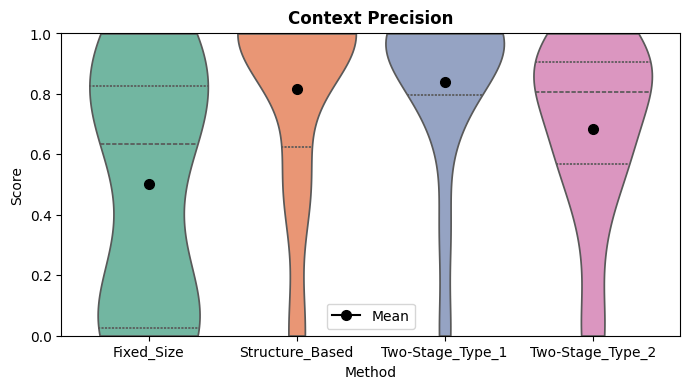

<ipython-input-28-440f366359f3>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(


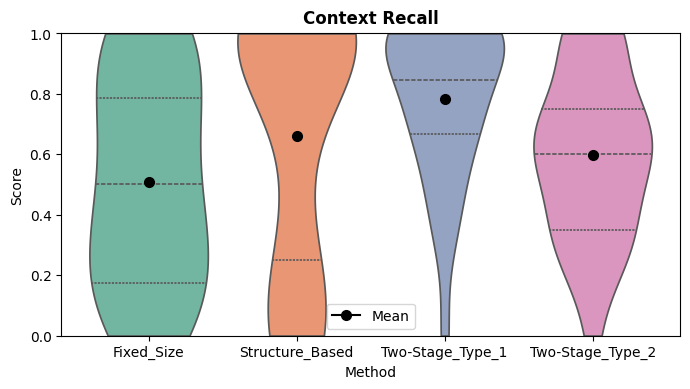

<ipython-input-28-440f366359f3>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(


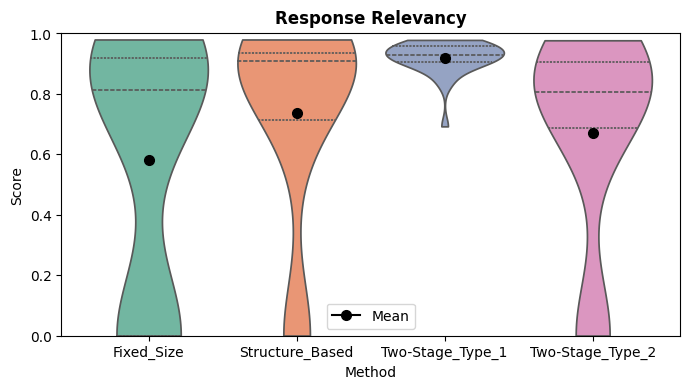

<ipython-input-28-440f366359f3>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(


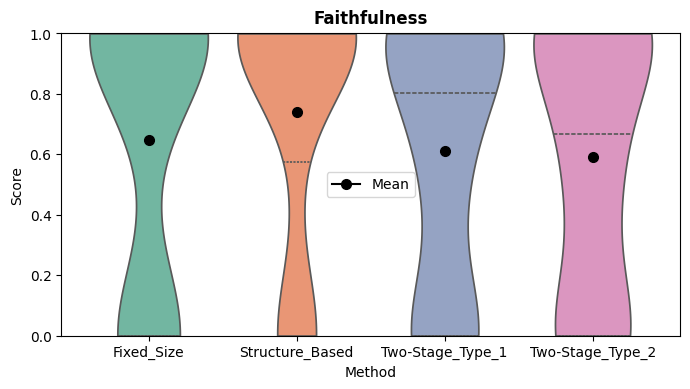

In [ ]:
# Combine all system DataFrames into one long-form DataFrame
combined_df = pd.concat([
    df.assign(Method=name) for name, df in eval_result.items()
])

# List of metrics to plot
metrics = metrics = ["Context_Precision", "Context_Recall", "Response_Relevancy", "Faithfulness"]

# Plot a violin plot for each metric
for metric in metrics:
    plt.figure(figsize=(7, 4))

    # Base violin plot
    ax = sns.violinplot(
        data=combined_df,
        x="Method",
        y=metric,
        palette="Set2",
        inner="quartile",  # shows median and IQR
        cut=0
    )

    # Overlay mean as black dot
    for i, system in enumerate(combined_df['Method'].unique()):
        mean_val = combined_df[combined_df['Method'] == system][metric].mean()
        plt.plot(i, mean_val, marker='o', markersize=7, color='black', label="Mean" if i == 0 else "")

    metric_title = metric.replace('_', ' ')
    bold_part = metric_title
    normal_part = "(30 Testing Samples)"
    # Plot title manually using `ax.text`
    ax.text(
        0.5, 1.05,  # Position above the plot
        f"{bold_part}",
        ha='center',
        va='center',
        transform=ax.transAxes,
        fontsize=12,
        fontweight='bold'
    )

    # # Now re-add the normal part with lighter weight
    # ax.text(
    #     0.5 + 0.01 * len(bold_part), 1.05,  # Slightly shifted right
    #     normal_part,
    #     ha='left',
    #     va='center',
    #     transform=ax.transAxes,
    #     fontsize=12,
    #     fontweight='normal'
    # )
    plt.ylabel("Score")
    plt.ylim(0, 1)
    plt.legend()
    plt.tight_layout()
    plt.show()

#### Question Type Analysis


##### Question lists

In [ ]:
fact_based_questions = [
    "who sang the theme tune to absolutely fabulous",
    "where did the annual wife carrying world championships take place",
    "when was figure skating introduced to the olympics",
    "who sings in the eye of the storm",
    "who won the primary for governor of illinois",
    "where did they film american horror story coven",
    "what film has the song don't you forget about me",
    "where is archangel raphael mentioned in the bible",
    "who sings the theme song to one tree hill",
    "who fired the first shot of the civil war at fort sumter",
    "who plays amy on the secret life of an american teenager",
    "when is the second sound of the heartbeat produced",
    "who plays chuck on the tv show chuck",
    "which olsen twin was in full house more",
    "how much money does argentina make from tourism",
    "who did the french revolt against in 1789",
    "who is the kicker for the new york giants",
    "who played the mom in lost in space 2018",
    "who recorded the song do you love me",
    "when did humans first occupy the international space station",
    "who played darth vader in the original trilogy",
    "what does c class stand for in mercedes benz",
    "how many episodes will prison break season 5 have",
    "when was the 1913 natives land act repealed",
    "where was best years of our lives filmed"
]

broad_questions = [
    "where is the best farming soil in the us and where did all the dirt come from",
    "summary of philip sidney an apology for poetry",
    "what is the main job of the pharynx",
    "how is the energy generated in a main sequence star",
    "what is the difference between priest and bishop"
]


##### Run analysis

In [ ]:
!pip install tabulate

In [ ]:
from tabulate import tabulate

In [ ]:
def get_question_type(q):
    if q in fact_based_questions:
        return "Fact-Based"
    elif q in broad_questions:
        return "Broad"
    else:
        return "Unknown"

In [ ]:
all_stats = []

for method, df in eval_result.items():
    with open(file_paths[method], 'r') as f:
        data = json.load(f)
    questions = [d['input_question'] for d in data]
    df['input_question'] = questions
    df['question_type'] = df['input_question'].apply(get_question_type)

    # Group by question type and compute mean scores
    grouped = df.groupby('question_type')[['Context_Precision', 'Context_Recall', 'Response_Relevancy', 'Faithfulness']].mean()

    for qtype, row in grouped.iterrows():
        row_dict = row.to_dict()
        row_dict['Method'] = method
        row_dict['Question_Type'] = qtype
        all_stats.append(row_dict)


In [ ]:
# Step 4: Final DataFrame
summary_df = pd.DataFrame(all_stats)
summary_df = summary_df[['Method', 'Question_Type', 'Context_Precision', 'Context_Recall', 'Response_Relevancy', 'Faithfulness']]
summary_df = summary_df.round(3)

# Extract subsets by question type
fact_based_df = summary_df[summary_df['Question_Type'] == 'Fact-Based']
broad_df = summary_df[summary_df['Question_Type'] == 'Broad']

# Drop the 'Question_Type' column and reset index
fact_based_clean = fact_based_df.drop(columns=['Question_Type']).reset_index(drop=True)
broad_clean = broad_df.drop(columns=['Question_Type']).reset_index(drop=True)

# Reorder columns (optional)
columns_order = ['Method', 'Context_Precision', 'Context_Recall', 'Response_Relevancy', 'Faithfulness']
fact_based_clean = fact_based_clean[columns_order]
broad_clean = broad_clean[columns_order]

# Pretty print with tabulate
from tabulate import tabulate

print("=== Fact-Based Questions Summary ===")
print(tabulate(fact_based_clean, headers="keys", tablefmt="grid", showindex=False))

print("\n=== Broad Questions Summary ===")
print(tabulate(broad_clean, headers="keys", tablefmt="grid", showindex=False))

=== Fact-Based Questions Summary ===
+------------------+---------------------+------------------+----------------------+----------------+
| Method           |   Context_Precision |   Context_Recall |   Response_Relevancy |   Faithfulness |
+==================+=====================+==================+======================+================+
| Fixed_Size       |               0.499 |            0.529 |                0.584 |          0.68  |
+------------------+---------------------+------------------+----------------------+----------------+
| Structure_Based  |               0.8   |            0.634 |                0.695 |          0.694 |
+------------------+---------------------+------------------+----------------------+----------------+
| Two-Stage_Type_1 |               0.819 |            0.754 |                0.922 |          0.581 |
+------------------+---------------------+------------------+----------------------+----------------+
| Two-Stage_Type_2 |               0.717 |   